# Finding brain regions and getting their center of mass using the Allen SDK

1. Create a new python virtual environment or use an existing one.
1. pip install allensdk==2.15.1 # this works with the current ubuntu/pipeline we have, you can try just doing pip install allensdk
1. The Allen data has to be download which happens in the commands below. You might get an error on downloading, if you do, just copy the link that is in the error message and use curl or wget or just put that link in the browser. It will then download. You will need to move that into the current working directory of this notebook under the 'mouse_connectivity' directory


In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage import center_of_mass
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from matplotlib import pyplot as plt

### Accessing the CCF from the MouseConnectivityCache

Instantiate the MouseConnectivityCache (mcc). The default resolution is 25 microns, but 10,50, and 100 microns are also valid options. You can also specify a location of a manifest file, which would keep track of all downloaded assets from template and annotation volumes to experimental data. If a manifest file directory is not provided, one will be created in the current working directory. (This is where you might get downloading errors, just download it manually and place it under the dir: mouse_connectivity'

In [2]:
mcc = MouseConnectivityCache(resolution=25)

#### Annotated Volume and Reference Space
Now you can get the Reference Space (rsp) at that resolution. This automatically downloads the annotated volume at the specified resolution (25 microns).

In [3]:
rsp = mcc.get_reference_space()

The annotated volume is a 3D numpy ndarray, with axes correspond to AP,DV, and ML respectively:

In [4]:
print('Type of annotated volume', type(rsp))
print('Shape of annotated volume:',rsp.annotation.shape)
print('Annotated volume data type:',rsp.annotation.dtype)

Type of annotated volume <class 'allensdk.core.reference_space.ReferenceSpace'>
Shape of annotated volume: (528, 320, 456)
Annotated volume data type: uint32


The rsp provides access to the structure tree from the ontology. Given that there are multiple atlases and associated ontologies, we are only interested in the structures belonging to this annotation. Thus, we remove unassigned structures from the structure tree. This returns a structure graph which is more easily viewed as a pandas DataFrame:

In [5]:
sg = rsp.remove_unassigned()

In [6]:
sg = pd.DataFrame(sg)

In [7]:
sg.head()

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,root,1,0,997,root,[997],[691663206],"[255, 255, 255]"
1,grey,1,1,8,Basic cell groups and regions,"[997, 8]","[112905828, 691663206, 12, 184527634, 11290581...","[191, 218, 227]"
2,CH,1,2,567,Cerebrum,"[997, 8, 567]","[112905828, 691663206, 12, 184527634, 11290581...","[176, 240, 255]"


In [ ]:
# I picked the cerebellum as it is easy to see
# get data with structure name
structure = 'inferior colliculus'
row = sg.loc[sg['name'] == structure]
row

In [53]:
# get data with acronym
# our facial nerve is 7n_L and 7n_R, Allen has it as VII
# SC = SCs, SNR = SNr
acronym = 'SCs'
row = sg.loc[sg['acronym'] == acronym]
row

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
536,SCs,1,808,302,"Superior colliculus, sensory related","[997, 8, 343, 313, 339, 302]","[112905828, 691663206, 687527945, 10, 12, 6881...","[255, 122, 255]"


In [16]:
#sg.query('name.str.contains("Superior colliculus")', engine='python')

In [54]:
structure_id = row.iat[0, 3]
print(structure_id)

302


In [55]:
# Get a list of acronymns
id_acronym_map = rsp.structure_tree.get_id_acronym_map() # Dictionary returns IDs given acronyms
acronym_id_map = {v:k for k,v in id_acronym_map.items()} # Flip key:value pairs to get dictionary for acronyms given IDs
print(list(map(acronym_id_map.get,rsp.structure_tree.descendant_ids([structure_id])[0])))

['SCs', 'SCop', 'SCsg', 'SCzo']


The structures' acronyms, names and IDs can all be linked through the structure graph.

While the rsp can be used to generate sections in the coronal (0), horizontal (1), or sagittal (2) planes:

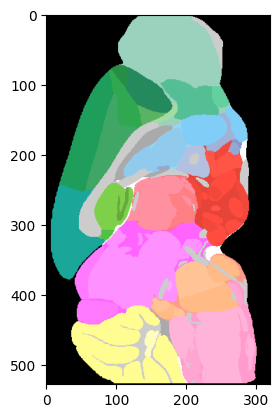

In [19]:
orientation = {'coronal':0,'horizontal':1,'sagittal':2} # makes orientation arguments more readible
pos_microns = lambda x:x*25 # get_slice_image function takes positional arguments in microns instead of 25 micron increments

img = rsp.get_slice_image(orientation['sagittal'],pos_microns(200))
plt.imshow(img)

The rsp can also generate masks of given structure IDs. The IDs are provided as a list, and by default include all voxels annotated as children of the given structures (direct_only=False). If only the parent level voxels are desired, set direct_only to True.

Here we make a mask of the Cerebral Cortex, which from the structure graph is shown to have the ID 688.

uint8 (528, 320, 456)
[76907626   138134]
Center of mass for 302: (368.08973894913635, 62.21607279887645, 227.68008600344592)


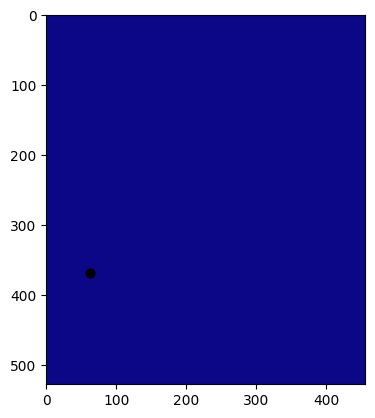

In [56]:
structure_mask = rsp.make_structure_mask([structure_id], direct_only=False)
ids, counts = np.unique(structure_mask, return_counts=True)
print(structure_mask.dtype, structure_mask.shape)
print(counts)
#structure_mask = np.swapaxes(structure_mask, 0, 2)
structure_mask = structure_mask * 254
com = center_of_mass(structure_mask)
print(f'Center of mass for {structure_id}: {com}')
# in structure_mask, first index would be coronal, 3rd is sagittal
i = int(com[2])
slice = structure_mask[:,i,:]
plt.scatter([com[1]], [com[0]], c='#000000', s=40)
plt.imshow(slice, cmap='plasma')
# Center of mass for 381: (337.62106378683893, 206.69036132418248, 227.7101836899475)
# This COM from the calculation is in the center of the two masses

In [57]:
print('Shape of entire brain', rsp.annotation.shape)
print('Shape of mask:',structure_mask.shape)
print('Mask data type:',structure_mask.dtype)
values, counts = np.unique(structure_mask, return_counts=True)
com = center_of_mass(structure_mask)
print(f'Center of mass for {structure_id}: {com}')

Shape of entire brain (528, 320, 456)
Shape of mask: (528, 320, 456)
Mask data type: uint8
Center of mass for 302: (368.08973894913635, 62.21607279887645, 227.68008600344592)


In [44]:
def create_com(structure_id):
    com = (0,0,0)
    try:
        structure_mask = rsp.make_structure_mask([structure_id], direct_only=False)
    except:
        structure_mask = None
    if structure_mask is not None:
        com = center_of_mass(structure_mask)
    return com
def round_com(com):
    x,y,z = com
    return (round(x,2), round(y,2), round(z,2))
def calculate_distance(id1, id2):
    com1 = create_com(id1)
    com2 = create_com(id2)
    a = np.array(com1).astype(np.float64)
    b = np.array(com2).astype(np.float64)
    return (np.linalg.norm(a-b))
    
com = create_com(structure_id)
print(com)
com_round = round_com(com)
print(com_round)

(368.08973894913635, 62.21607279887645, 227.68008600344592)
(368.09, 62.22, 227.68)


In [42]:
SC_id = 302
IC_id = 811
V_id = 621

In [45]:
calculate_distance(SC_id, IC_id)

57.18802294621099

In [ ]:
#sg['com'] = create_com(sg['id'])
sg['com'] = sg['id'].apply(create_com)

In [ ]:
sg['com_rounded'] = sg['com'].apply(round_com)

In [ ]:
df = sg.drop(sg.columns[[1, 2, 5,6,7,8]], axis=1)

In [ ]:
sg.head()

In [ ]:
df.head()

In [ ]:
outfile = '/home/eddyod/allen-coms.csv'
com_df.to_csv(outfile, index=False)

In [ ]:
infile = '/home/eddyod/sql/allen.DK52.COMS.csv'
com_df = pd.read_csv(infile)
com_df.head()

In [ ]:
#com_df['distance_l'] = com_df[['allen_com', 'dk52_l_com']].apply(calculate_distance)
com_df['distance_l'] = com_df.apply(lambda x: calculate_distance(x.allen_com, x.dk52_l_com), axis=1)

In [ ]:
com_df.head(20)